In [4]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

In [7]:
def open_fifa_version_df(fifa_version):
    df = pd.read_csv('fifa-22-complete-player-dataset\players_' + str(fifa_version) + '.csv', low_memory = False)
    df['fifa_version'] = int(fifa_version)
    new_cols_order = ['fifa_version'] + df.columns.to_list()[:-6] # removing picture URLs
    df = df[new_cols_order]
    return df


players_df = pd.DataFrame()
for fifa_version in range(15, 23): # upper bound excluded from range
    players_df = players_df.append(open_fifa_version_df(fifa_version))
print(len(players_df))

142079


In [8]:
from pycaret.regression import *

In [9]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [10]:
Eligible_features = ['fifa_version',  'value_eur','wage_eur' ,'age',
       'height_cm', 'weight_kg',  'club_name', 'league_name',
       'league_level', 'club_position', 'league_level','club_contract_valid_until',  'nationality_name', 'club_joined', 'preferred_foot', 'international_reputation', 'work_rate',
       'body_type', 'release_clause_eur']
       
players_df = players_df[Eligible_features]
players_df = players_df[players_df["value_eur"].notna()]
players_df = players_df[players_df["club_contract_valid_until"].notna()]
players_df['fifa_version'] = '20' + players_df['fifa_version'].astype(str)

players_df['fifa_version'] = pd.to_datetime(players_df['fifa_version'], format="%Y")
players_df['club_joined'] = pd.to_datetime(players_df['club_joined'], format="%Y/%m/%d")
players_df['club_contract_valid_until'] = players_df['club_contract_valid_until'].astype(str)
players_df['club_contract_valid_until'].str.strip().str[-1].value_counts()

players_df['club_contract_valid_until'] = players_df['club_contract_valid_until'].str[:-2]
players_df['club_contract_valid_until'] = pd.to_datetime(players_df['club_contract_valid_until'], format="%Y")
players_df['contract_left_days'] =  players_df['club_contract_valid_until'] -  players_df['fifa_version']
players_df['days_at_club'] = players_df['fifa_version'] - players_df['club_joined']

players_df['body_type'] = players_df['body_type'].str.split('(').str[0]
players_df['work_rate'] = players_df['work_rate'].str.split('/').str[0]

cat_cols = ['club_name', 'league_name', 'club_position', 'nationality_name',
       'preferred_foot', 'work_rate', 'body_type']
players_df[cat_cols] = players_df[cat_cols].astype(str)
players_df["contract_left_days"] = players_df["contract_left_days"].dt.days
players_df["days_at_club"] = players_df["days_at_club"].dt.days
players_df = players_df.loc[:, ~players_df.columns.duplicated()]
players_df.drop(columns=['fifa_version','club_contract_valid_until','club_joined'],inplace=True)
players_df['wage_eur'] = players_df['wage_eur'] * 52
# weekly salary to annual salary

In [11]:
## PYCARET

In [12]:
num_features = ['value_eur', 'age', 'height_cm', 'weight_kg',
        'release_clause_eur', 'contract_left_days',
       'days_at_club']

cat_features = ['club_name', 'league_name',  'league_level','club_position','international_reputation', 'nationality_name',
       'preferred_foot', 'work_rate', 'body_type']

In [13]:
players_df.head(3)

,value_eur,wage_eur,age,height_cm,weight_kg,club_name,league_name,league_level,club_position,nationality_name,preferred_foot,international_reputation,work_rate,body_type,release_clause_eur,contract_left_days,days_at_club
0,100500000.0,28600000.0,27,169,67,FC Barcelona,Spain Primera Division,1.0,CF,Argentina,Left,5,Medium,Normal,NaN,1096,3836.0
1,79000000.0,19500000.0,29,185,80,Real Madrid CF,Spain Primera Division,1.0,LW,Portugal,Right,5,High,Normal,NaN,1096,2010.0
2,54500000.0,14300000.0,30,180,80,FC Bayern München,German 1. Bundesliga,1.0,SUB,Netherlands,Left,5,High,Normal,NaN,731,1952.0


In [14]:
s = setup(data = players_df, 
          target = 'wage_eur', 
          train_size = 0.85,
          categorical_features = list(cat_features),
          numeric_features = list(num_features),
          ordinal_features = {'work_rate' : ['Low', 'Medium', 'High']},
          session_id=42,
          fold_strategy= 'kfold', 
          fold = 3)

,Description,Value
0,session_id,42
1,Target,wage_eur
2,Original Data,"(140174, 17)"
3,Missing Values,True
4,Numeric Features,7
5,Categorical Features,9
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(119147, 1302)"


In [15]:
# train xgboost model on gpu
lgbm = create_model('lightgbm') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,163877.9211,111704404307.5221,334222.0883,0.9118,0.5726,0.6228
1,164538.9405,127594456528.5797,357203.6625,0.9100,0.5874,0.6370
2,164745.2491,119850687514.0662,346194.5804,0.9110,0.5857,0.6202
Mean,164387.3702,119716516116.7226,345873.4438,0.9109,0.5819,0.6267
SD,369.9501,6487780379.0348,9384.9360,0.0007,0.0066,0.0074


In [16]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,70,5),
                        'max_depth': np.arange(6, 50, 3)
                        }
                        
tuned_lightgbm = tune_model(lgbm, custom_grid = lgbm_params)
print(tuned_lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,151032.5521,100037322339.9090,316286.7723,0.9210,0.5374,0.5488
1,151934.5721,117516232689.0960,342806.4070,0.9171,0.5467,0.5621
2,150752.3508,106942067640.3367,327019.9805,0.9206,0.5365,0.5496
Mean,151239.8250,108165207556.4472,328704.3866,0.9196,0.5402,0.5535
SD,504.4028,7187958921.6743,10891.9136,0.0017,0.0046,0.0061


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=48,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=65, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


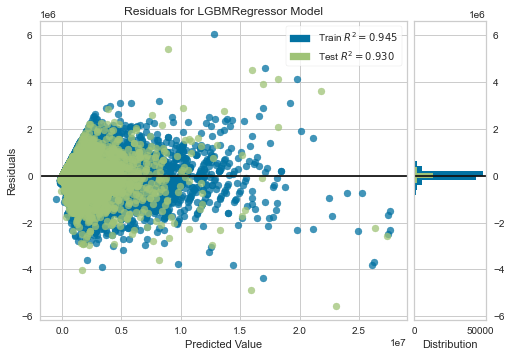

In [17]:
plot_model(tuned_lightgbm)

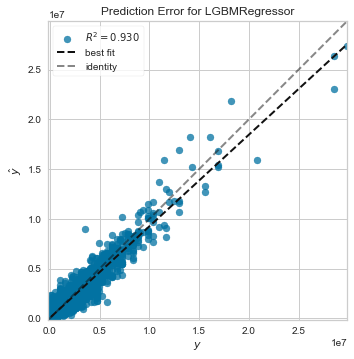

In [19]:
plot_model(tuned_lightgbm, plot = 'error')

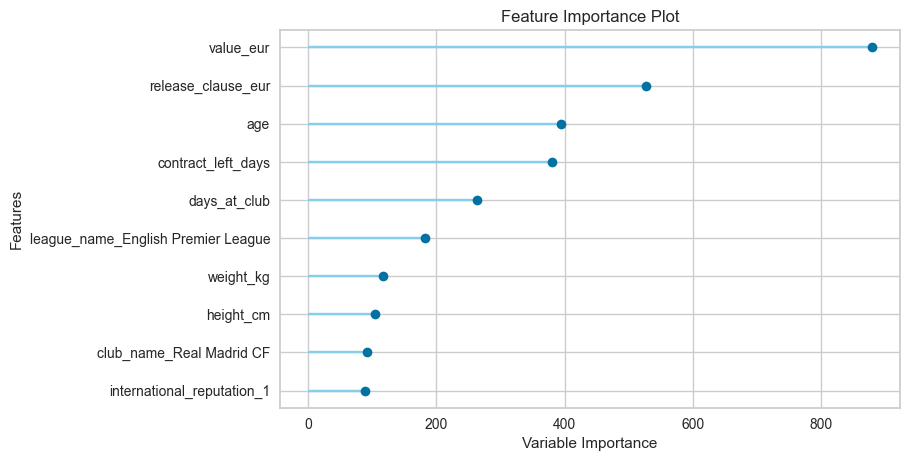

In [18]:
plot_model(tuned_lightgbm, plot='feature')

In [20]:
create_app(tuned_lightgbm)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x258caaaed08>,
 'http://127.0.0.1:7860/',
 None)